In [3]:
#Data import and manipulation
import pandas as pd
import numpy as np

#For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#Splitting Data
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV 

#To build model for prediction
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

In [4]:
df = pd.read_csv('./Bike Rental.csv')
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [5]:
#Remove the unnecessary columns.
#removing the dteday as we have date parts alreadye extracted
df = df.drop('dteday', axis=1)

#removing casual and registered as the sum of both is already present as cnt which is our target variable
df = df.drop(['casual','registered'], axis=1)

#removing instant as it has high cardinality and it is a serial number
df = df.drop('instant', axis=1)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      731 non-null    int64  
 1   yr          731 non-null    int64  
 2   mnth        731 non-null    int64  
 3   holiday     731 non-null    int64  
 4   weekday     731 non-null    int64  
 5   workingday  731 non-null    int64  
 6   weathersit  731 non-null    int64  
 7   temp        731 non-null    float64
 8   atemp       731 non-null    float64
 9   hum         731 non-null    float64
 10  windspeed   731 non-null    float64
 11  cnt         731 non-null    int64  
dtypes: float64(4), int64(8)
memory usage: 68.7 KB


In [7]:
df.describe()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,2.496580,0.500684,6.519836,0.028728,2.997264,0.683995,1.395349,0.495385,0.474354,0.627894,0.190486,4504.348837
std,1.110807,0.500342,3.451913,0.167155,2.004787,0.465233,0.544894,0.183051,0.162961,0.142429,0.077498,1937.211452
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.059130,0.079070,0.000000,0.022392,22.000000
25%,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,0.337083,0.337842,0.520000,0.134950,3152.000000
50%,3.000000,1.000000,7.000000,0.000000,3.000000,1.000000,1.000000,0.498333,0.486733,0.626667,0.180975,4548.000000
75%,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,0.655417,0.608602,0.730209,0.233214,5956.000000
max,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,0.861667,0.840896,0.972500,0.507463,8714.000000


In [8]:
df.shape

(731, 12)

In [9]:
df.isnull().sum()

season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
cnt           0
dtype: int64

In [10]:
df.duplicated().sum()

0

## Observations
1. There are no null values within the dataset
2. There are no duplicates in the dataset
3. We have date parts already extracted in the dataset  in the form of yr, mnth, hr, weekday, etc. Since we do not require need to perform any further operations, we can drop the variable.
4. After looking at the data we dropped the instant which represents the id and casual and registered columns since casual+registered=cnt(target
5. The temp and atemp ranges  are quite same. We can take a look into correlation anaysis of how much these variabales are related to each other.

In [11]:
numerical_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object','category']).columns.tolist()

In [12]:
numerical_cols.remove('season')
numerical_cols.remove('yr')
numerical_cols.remove('mnth')
numerical_cols.remove('holiday')
numerical_cols.remove('weekday')
numerical_cols.remove('workingday')
numerical_cols.remove('weathersit')

In [13]:
categorical_cols.extend(['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit'])

In [14]:
categorical_cols

['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']

In [15]:
def univariate_numerical_analysis(df, column, figsize=(8,6), bins=10, kde=False):
    f2, ax_hist = plt.subplots(nrows=1, figsize=figsize)
    
    sns.histplot(data=df, x=column, ax=ax_hist, bins=bins, color='lightsalmon')
    ax_hist.axvline(df[column].mean(), color='green', linestyle='--')
    ax_hist.axvline(df[column].mean(), color='black', linestyle='--')

In [16]:
def univariate_categorical_analysis(df, column):
    print("Percentage Distribution for", column)
    print(df[column].value_counts(normalize=True) * 100)
    print()
    
    plt.figure(figsize=(8,6))
    df[column].value_counts().plot(kind='bar', color='lightsalmon')
    plt.title("Bar Plot:" + column)
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.show()

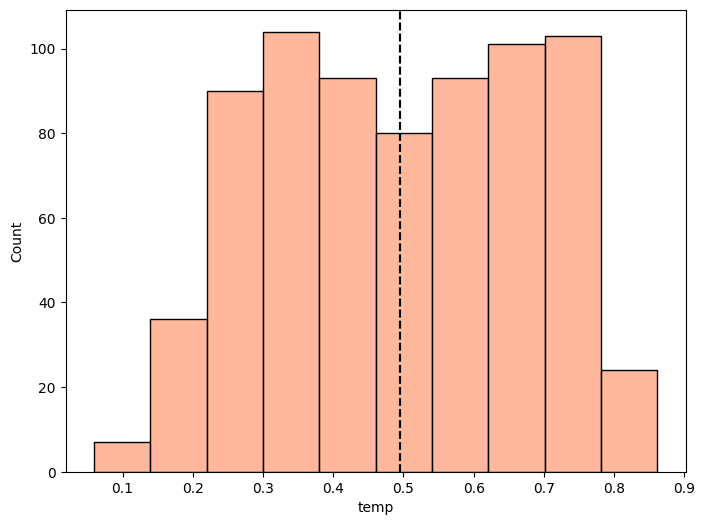

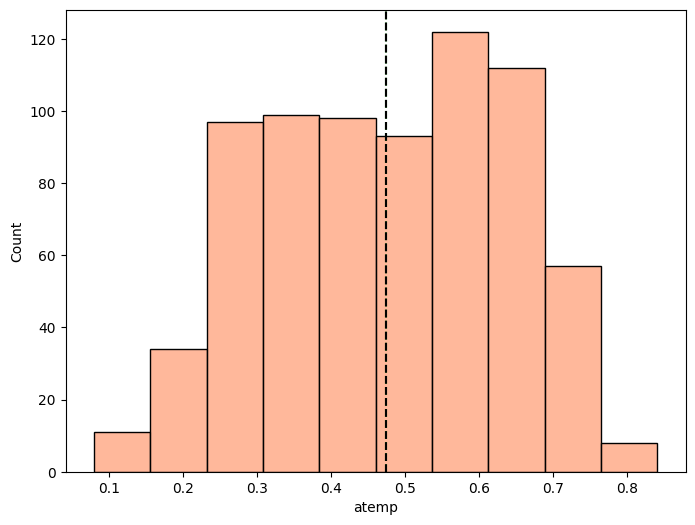

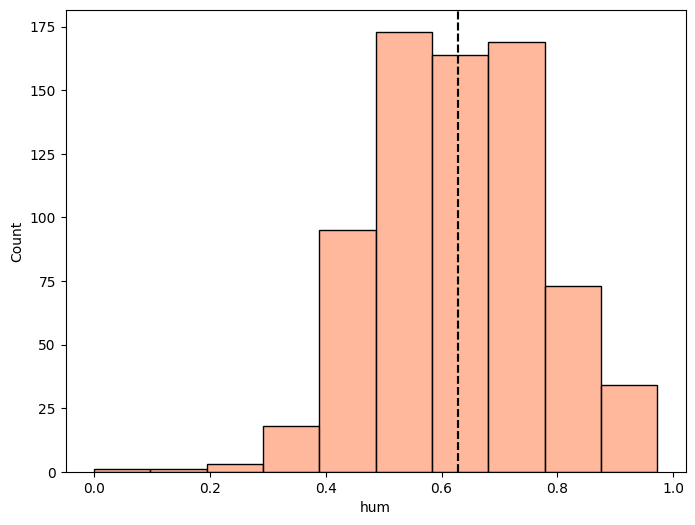

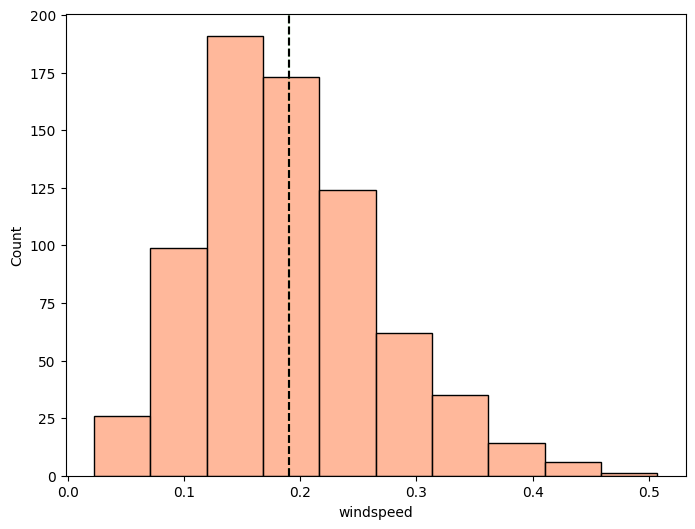

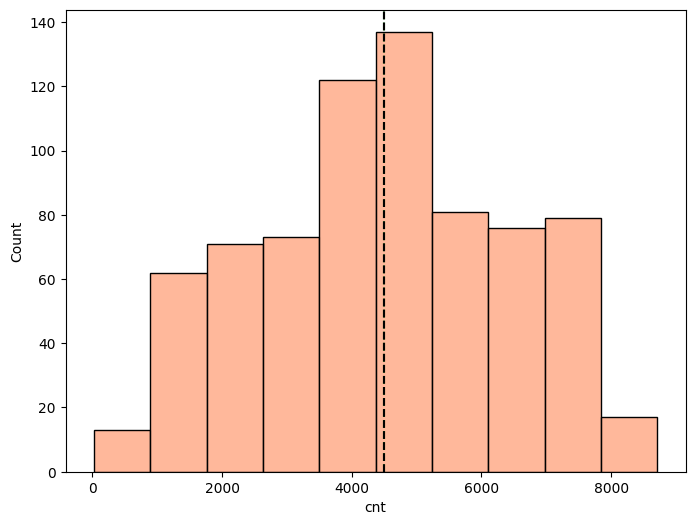

In [17]:
for col in numerical_cols:
    univariate_numerical_analysis(df, col)

Percentage Distribution for season
3    25.718194
2    25.170999
1    24.760602
4    24.350205
Name: season, dtype: float64



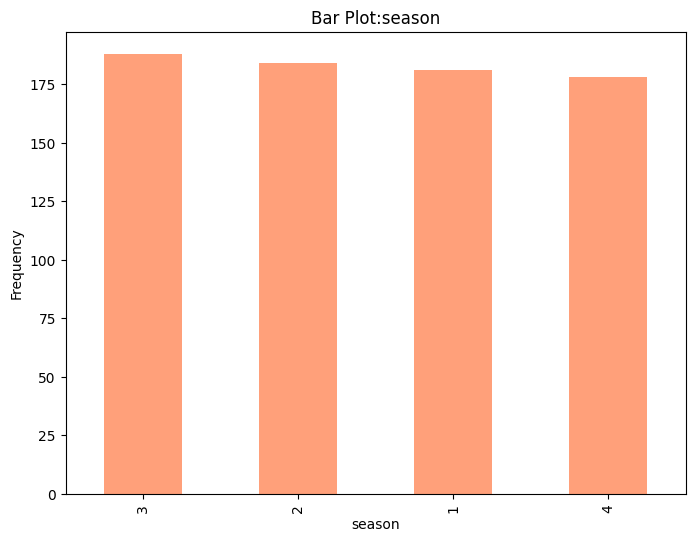

Percentage Distribution for yr
1    50.068399
0    49.931601
Name: yr, dtype: float64



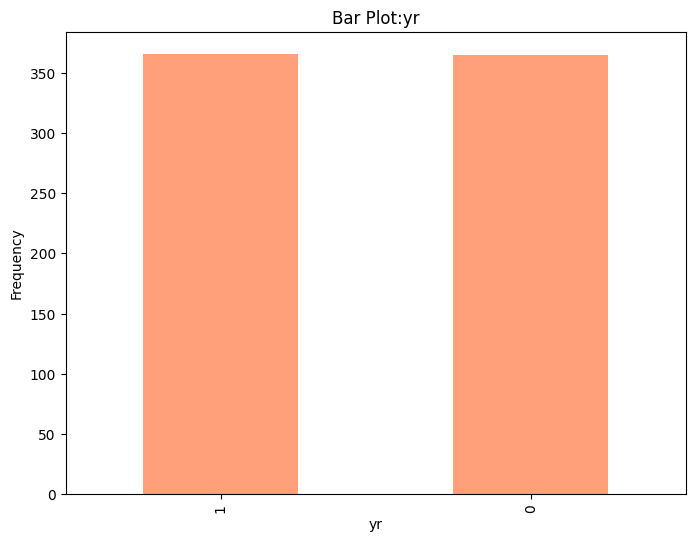

Percentage Distribution for mnth
1     8.481532
3     8.481532
5     8.481532
7     8.481532
8     8.481532
10    8.481532
12    8.481532
4     8.207934
6     8.207934
9     8.207934
11    8.207934
2     7.797538
Name: mnth, dtype: float64



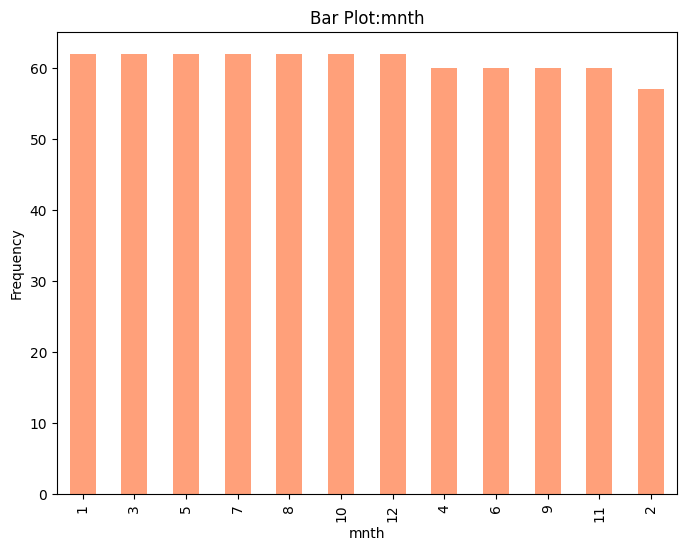

Percentage Distribution for holiday
0    97.127223
1     2.872777
Name: holiday, dtype: float64



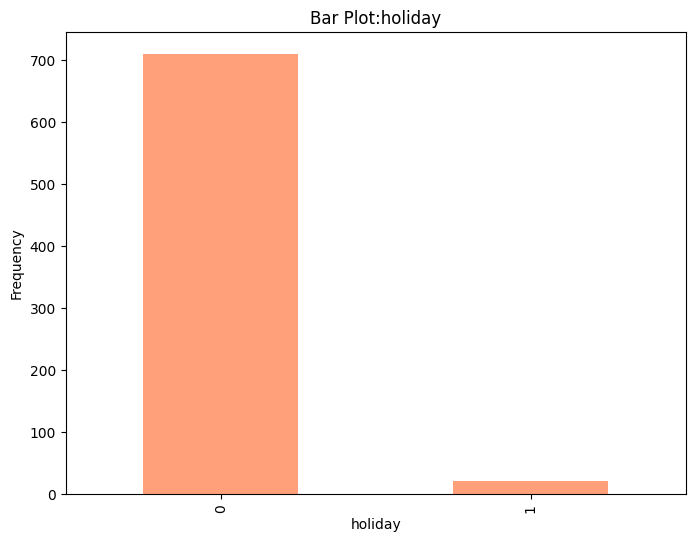

Percentage Distribution for weekday
6    14.363885
0    14.363885
1    14.363885
2    14.227086
3    14.227086
4    14.227086
5    14.227086
Name: weekday, dtype: float64



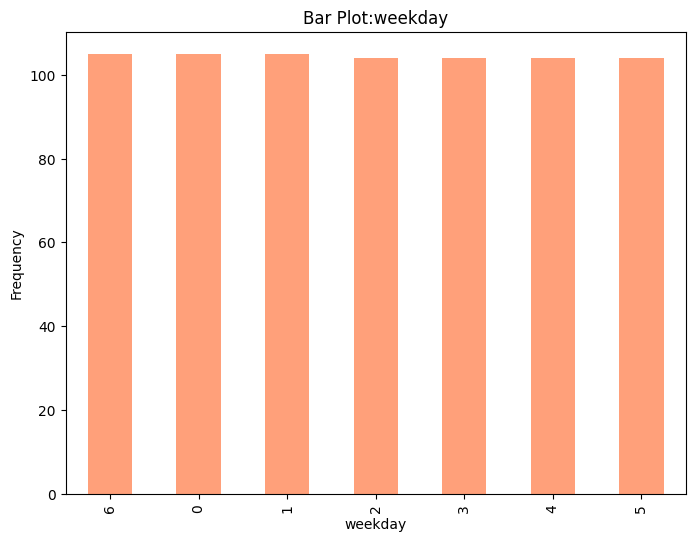

Percentage Distribution for workingday
1    68.399453
0    31.600547
Name: workingday, dtype: float64



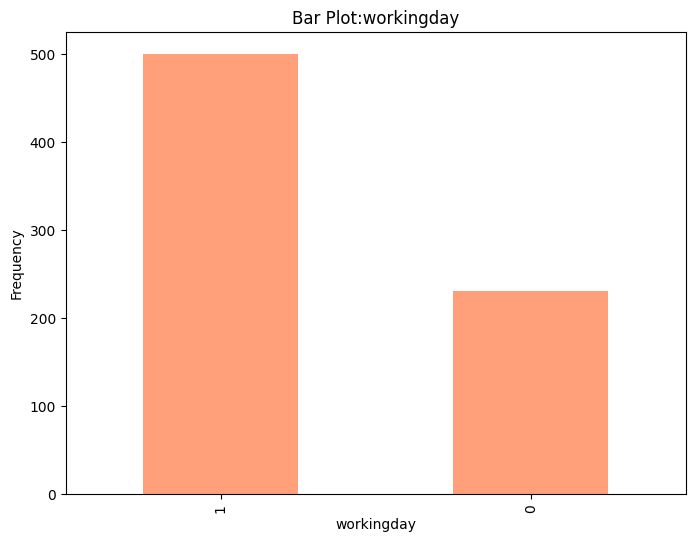

Percentage Distribution for weathersit
1    63.337893
2    33.789330
3     2.872777
Name: weathersit, dtype: float64



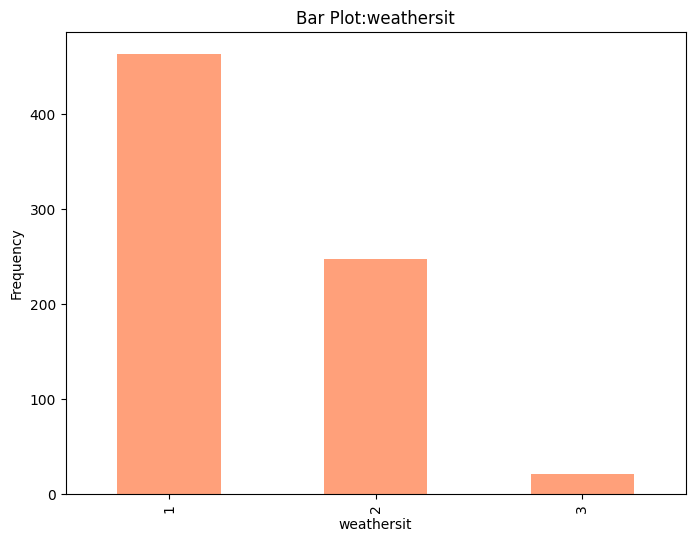

In [18]:
for col in categorical_cols:
    univariate_categorical_analysis(df, col)

## Observations
1. Most of the numerical variables follow normal distribution variables with skewness within the data for instance, humidity and windspeeed. We will keep using these variables as they are real time values and we don't see much extremes
2. Time related variables shows pretty balanced performances. These variables shows uniform distributions.
3. We see an expected different in working vs non-working day where working days have high frequency compared to non-working days.
4. The weathersit variable also shows an expected distribution. Since higher values defines worst weather, we expect to see value 4 with the lowest frequency.

# Bivariate Analysis

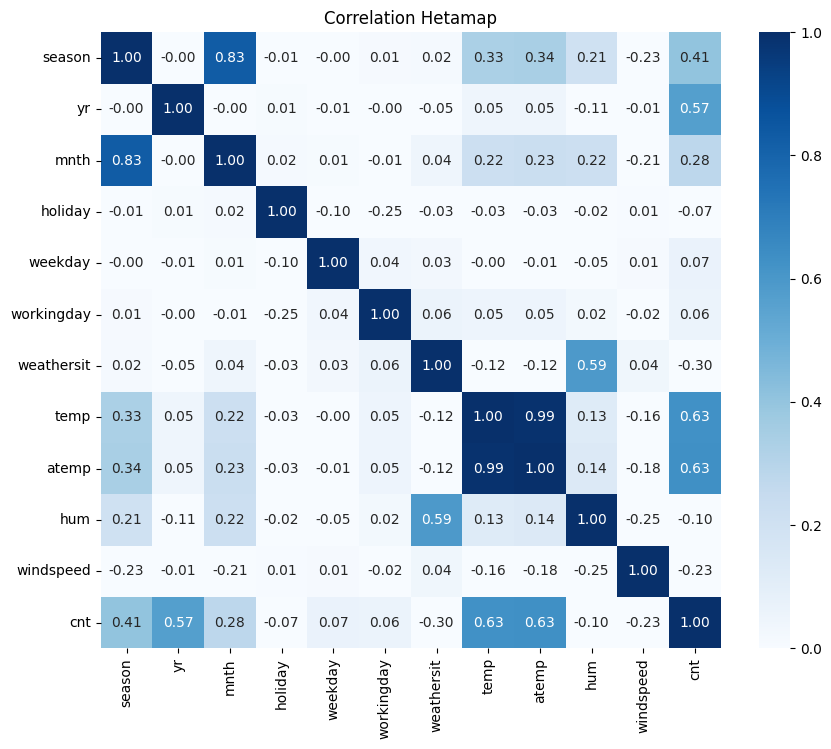

In [19]:
corr = df.corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, vmin= 0, vmax= 1, annot= True, cmap='Blues' , fmt= ".2f")
plt.title('Correlation Hetamap')
plt.show()

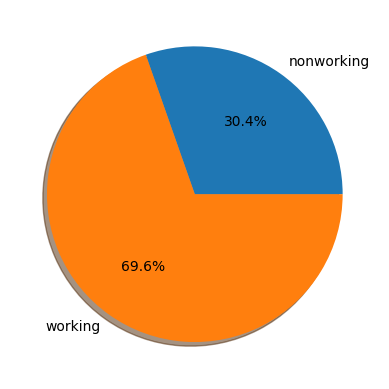

In [20]:
c = df.groupby('workingday')['cnt'].sum().reset_index()
c1 = c.sort_values(by='cnt')
y=c1['cnt']
labels=['nonworking', 'working']
plt.pie(y, labels=labels, shadow=True, autopct='%1.1f%%')
plt.show()

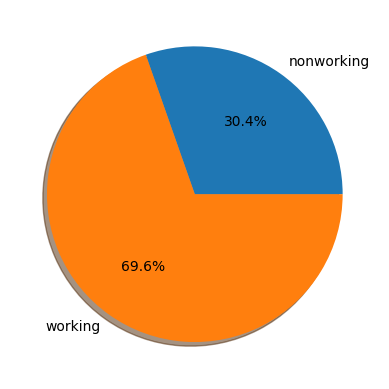

In [21]:
c = df.groupby('workingday')['cnt'].sum().reset_index() #Calculate the sum of count of bike rentals with respect to workingday
c1 = c.sort_values(by='cnt')
y=c1['cnt']
labels=['nonworking', 'working']
plt.pie(y, labels=labels, shadow=True, autopct='%1.1f%%')
plt.show()

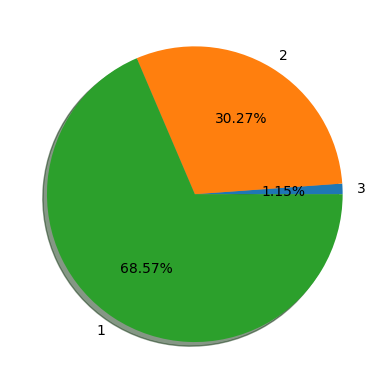

In [22]:
c = df.groupby('weathersit')['cnt'].sum().reset_index()
c1 = c.sort_values(by='cnt')
y=c1['cnt']
labels=[3,2,1]
plt.pie(y, labels=labels, shadow=True, autopct='%1.2f%%')
plt.show()

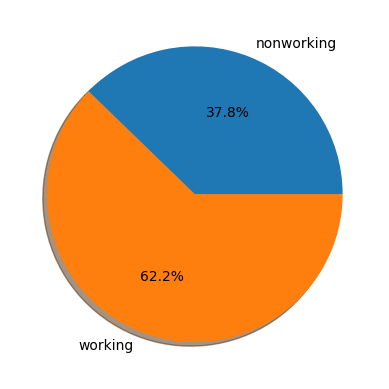

In [23]:
c = df.groupby('yr')['cnt'].sum().reset_index()
c1 = c.sort_values(by='cnt')
y=c1['cnt']
labels=['nonworking', 'working']
plt.pie(y, labels=labels, shadow=True, autopct='%1.1f%%')
plt.show()

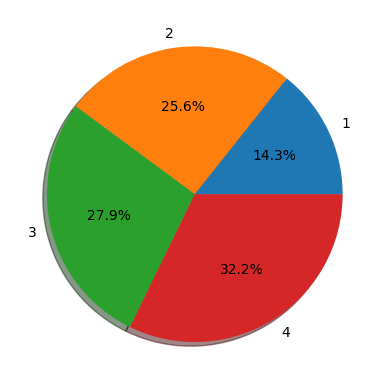

In [24]:
c = df.groupby('season')['cnt'].sum().reset_index()
c1 = c.sort_values(by='cnt')
y=c1['cnt']
labels=[1,2,3,4]
plt.pie(y, labels=labels, shadow=True, autopct='%1.1f%%')
plt.show()

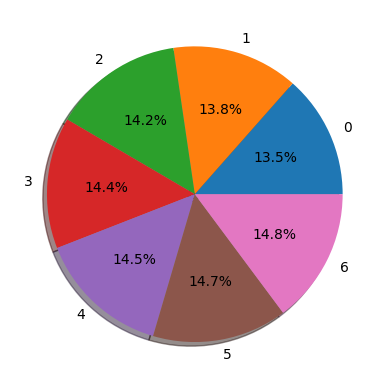

In [25]:
c = df.groupby('weekday')['cnt'].sum().reset_index()
c1 = c.sort_values(by='cnt')
y=c1['cnt']
labels=[0,1,2,3,4,5,6]
plt.pie(y, labels=labels, shadow=True, autopct='%1.1f%%')
plt.show()

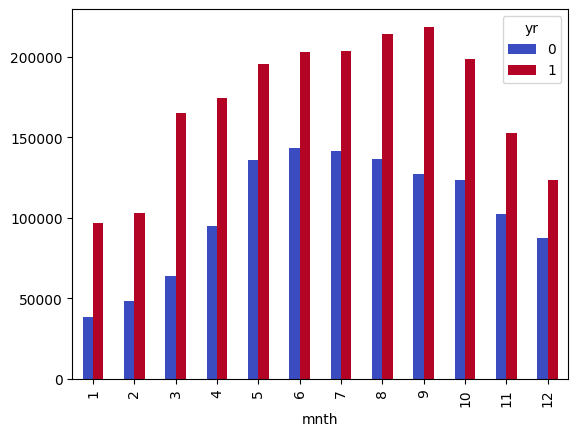

In [26]:
df.pivot_table(index='mnth', columns='yr', values='cnt', aggfunc='sum').plot(kind='bar', colormap='coolwarm')
plt.show()

In [27]:
#temp and atemp are same therefore it will create multicollinearity and doesn't help model

df.drop('atemp', axis= 1, inplace= True) 

## Data Preprocessing

In [28]:
df = pd.get_dummies(df, columns=['season'], drop_first=True)
df.head()

,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,season_2,season_3,season_4
0,0,1,0,6,0,2,0.344167,0.805833,0.160446,985,0,0,0
1,0,1,0,0,0,2,0.363478,0.696087,0.248539,801,0,0,0
2,0,1,0,1,1,1,0.196364,0.437273,0.248309,1349,0,0,0
3,0,1,0,2,1,1,0.200000,0.590435,0.160296,1562,0,0,0
4,0,1,0,3,1,1,0.226957,0.436957,0.186900,1600,0,0,0


## Train Test Split

In [29]:
X = df.drop('cnt', axis=1)
Y = df['cnt']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=30)

In [30]:
print('Training set shape', X_train.shape)
print('Testing set shape', X_test.shape)

print('Training set distribution:')
print(f'Avg: {y_train.mean()}, SD: {y_train.std()}')

print('Testing set distribution:')
print(f'Avg: {y_test.mean()}, SD: {y_test.std()}')

Training set shape (511, 12)
Testing set shape (220, 12)
Training set distribution:
Avg: 4460.743639921722, SD: 1958.4396937742679
Testing set distribution:
Avg: 4605.631818181818, SD: 1887.484711211203


## Apply Decision Tree Model

In [31]:
model = DecisionTreeRegressor()
model.fit(X_train, y_train)

DecisionTreeRegressor()

In [32]:
model.score(X_train, y_train)

1.0

In [33]:
model.score(X_test, y_test)

0.7574459846076698

In [34]:
y_pred_train = model.predict(X_train)

#Error Metrics
print('mean absolute error:', mean_absolute_error(y_train, y_pred_train))
print('mean squared error:', mean_squared_error(y_train, y_pred_train))
print('root mean squared error:', np.sqrt(mean_squared_error(y_train, y_pred_train)))
print('r2-score:', r2_score(y_train, y_pred_train))

mean absolute error: 0.0
mean squared error: 0.0
root mean squared error: 0.0
r2-score: 1.0


In [35]:
y_pred_test = model.predict(X_test)

#Error Metrics
print('mean absolute error:', mean_absolute_error(y_test, y_pred_test))
print('mean squared error:', mean_squared_error(y_test, y_pred_test))
print('root mean squared error:', np.sqrt(mean_squared_error(y_test, y_pred_test)))
print('r2-score:', r2_score(y_test, y_pred_test))

mean absolute error: 647.6045454545455
mean squared error: 860194.75
root mean squared error: 927.4668457686237
r2-score: 0.7574459846076698


## Observations
1. After fitting the model, we can see that decision tree is still overfitting even though we have gone through steps of the feature reduction and data  preprocessing
2. The model is not only learing the patterns but also the errors.
3. To overecome this we can apply pre pruning i.e. Hyperparameter Tuning and post pruning.

# Pre Pruning
## Hyperparameter Tuning

#### Grid search with Cross Validation

In [38]:
clf = DecisionTreeRegressor()

#Parameter to choose for gridsearchcv
parameter = {
    "max_depth": np.arange(3, 10, 1),
    "max_leaf_nodes": [50, 75, 150, 250, 300],
    "min_samples_split": [10, 20, 30, 50, 70, 100]
}

#Run the grid search
_grid_obj = GridSearchCV(clf, parameter, cv = 5, verbose = 1)
_grid_obj = _grid_obj.fit(X_train, y_train)

#Set the clf to the best combination of parameters
grid_clf = _grid_obj.best_estimator_
print(grid_clf)

Fitting 5 folds for each of 210 candidates, totalling 1050 fits
DecisionTreeRegressor(max_depth=8, max_leaf_nodes=50, min_samples_split=30)


In [39]:
# Fit the best algorithm to the data
grid_clf.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=8, max_leaf_nodes=50, min_samples_split=30)

In [40]:
print('mean absolute error:', mean_absolute_error(y_train, grid_clf.predict(X_train)))
print('mean squared error:', mean_squared_error(y_train, grid_clf.predict(X_train)))
print('root mean squared error:', np.sqrt(mean_squared_error(y_train, grid_clf.predict(X_train))))
print('r2-score:', r2_score(y_train, grid_clf.predict(X_train)))

mean absolute error: 461.23542784817494
mean squared error: 418926.64117022627
root mean squared error: 647.2454257623041
r2-score: 0.8905619621035106


In [41]:
print('mean absolute error:', mean_absolute_error(y_test, grid_clf.predict(X_test)))
print('mean squared error:', mean_squared_error(y_test, grid_clf.predict(X_test)))
print('root mean squared error:', np.sqrt(mean_squared_error(y_test, grid_clf.predict(X_test))))
print('r2-score:', r2_score(y_test, grid_clf.predict(X_test)))

mean absolute error: 630.425342224564
mean squared error: 809536.1232188889
root mean squared error: 899.742253769872
r2-score: 0.7717304862743214


#### Randomized Search with cross validation

In [42]:
clf = DecisionTreeRegressor()

#Parameter to choose for gridsearchcv
parameter = {
    "max_depth": np.arange(3,10,1),
    "max_leaf_nodes": [50, 75, 150, 250, 300],
    "min_samples_split": [10, 20, 30, 50, 70, 100]
}

#Run the randomized search
_grid_obj = RandomizedSearchCV(clf, parameter, cv = 5, verbose = 1)
_grid_obj = _grid_obj.fit(X_train, y_train)

#Set the clf to the best combination of parameters
random_clf = _grid_obj.best_estimator_
print(random_clf)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
DecisionTreeRegressor(max_depth=6, max_leaf_nodes=75, min_samples_split=30)


In [43]:
# Fir the best algorithm to the data
random_clf.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=6, max_leaf_nodes=75, min_samples_split=30)

In [44]:
print('mean absolute error:', mean_absolute_error(y_train, random_clf.predict(X_train)))
print('mean squared error:', mean_squared_error(y_train, random_clf.predict(X_train)))
print('root mean squared error:', np.sqrt(mean_squared_error(y_train, random_clf.predict(X_train))))
print('r2-score:', r2_score(y_train, random_clf.predict(X_train)))

mean absolute error: 478.9902320821376
mean squared error: 452214.98244249856
root mean squared error: 672.4693171011586
r2-score: 0.8818659031861549


In [45]:
print('mean absolute error:', mean_absolute_error(y_test, random_clf.predict(X_test)))
print('mean squared error:', mean_squared_error(y_test, random_clf.predict(X_test)))
print('root mean squared error:', np.sqrt(mean_squared_error(y_test, random_clf.predict(X_test))))
print('r2-score:', r2_score(y_test, random_clf.predict(X_test)))

mean absolute error: 627.492764881873
mean squared error: 801113.3178082916
root mean squared error: 895.0493381977843
r2-score: 0.7741055127124723


# Post Pruning

## Cost Complexity pruning

In [46]:
clf = DecisionTreeRegressor()
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = abs(path.ccp_alphas), path.impurities

In [47]:
pd.DataFrame(path)

,ccp_alphas,impurities
0,0.000000e+00,0.000000e+00
1,9.784736e-04,9.784736e-04
2,9.784736e-04,1.956947e-03
3,9.784736e-04,2.935421e-03
4,3.913894e-03,6.849315e-03
...,...,...
471,9.926380e+04,9.745222e+05
472,1.905708e+05,1.165093e+06
473,3.014349e+05,1.466528e+06
474,7.688031e+05,2.235331e+06


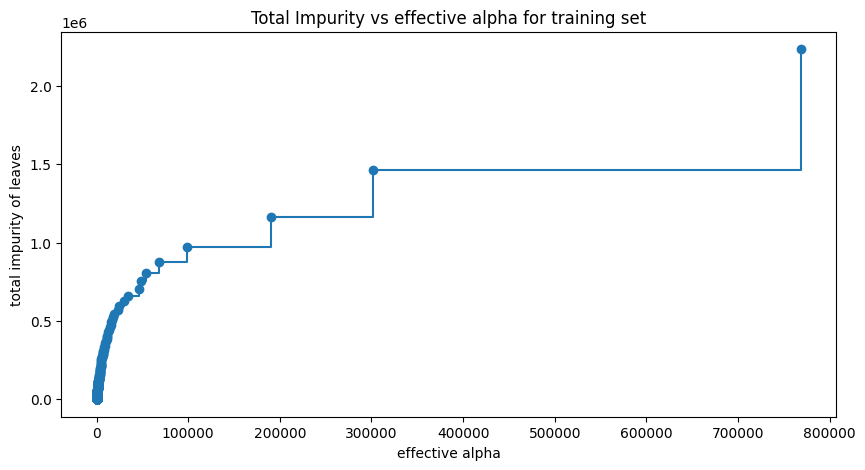

In [48]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(ccp_alphas[:-1], impurities[:-1],marker="o", drawstyle = "steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")
plt.show()

In [49]:
clfs=[]
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeRegressor(
    ccp_alpha=ccp_alpha
    )
    clf.fit(X_train, y_train)
    clfs.append(clf)

print("Number of nodes in the last tree is:{} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

Number of nodes in the last tree is:1 with ccp_alpha: 1592649.2417958742


In [50]:
r_squared_train = []
for clf in clfs:
    pred_train = clf.predict(X_train)
    r2_train = r2_score(y_train, pred_train)
    r_squared_train.append(r2_train)

In [51]:
r_squared_test = []
for clf in clfs:
    pred_test = clf.predict(X_test)
    r2_test = r2_score(y_test, pred_test)
    r_squared_test.append(r2_test)

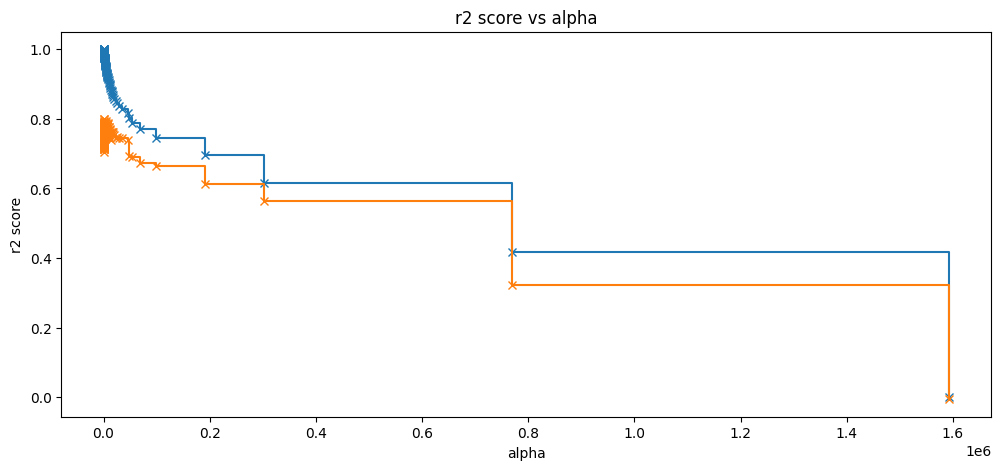

In [52]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.set_xlabel("alpha")
ax.set_ylabel("r2 score")
ax.set_title("r2 score vs alpha")
ax.plot(ccp_alphas, r_squared_train, marker="x", label="train data", drawstyle = "steps-post")
ax.plot(ccp_alphas, r_squared_test, marker="x", label="test data", drawstyle = "steps-post")
plt.show()

In [54]:
# Creating a model where we get highest test r2 score
index_best_test_model = np.argmax(r_squared_test)
best_model_test = clfs[index_best_test_model]
print(best_model_test)

DecisionTreeRegressor(ccp_alpha=469.69644021994105)


In [58]:
print('mean absolute error:', mean_absolute_error(y_train, best_model_test.predict(X_train)))
print('mean squared error:', mean_squared_error(y_train, best_model_test.predict(X_train)))
print('root mean squared error:', np.sqrt(mean_squared_error(y_train, best_model_test.predict(X_train))))
print('r2-score:', r2_score(y_train, best_model_test.predict(X_train)))

mean absolute error: 123.32066227451952
mean squared error: 27151.503427433396
root mean squared error: 164.77713259865095
r2-score: 0.9929070940612948


In [59]:
print('mean absolute error:', mean_absolute_error(y_test, best_model_test.predict(X_test)))
print('mean squared error:', mean_squared_error(y_test, best_model_test.predict(X_test)))
print('root mean squared error:', np.sqrt(mean_squared_error(y_test, best_model_test.predict(X_test))))
print('r2-score:', r2_score(y_test, best_model_test.predict(X_test)))

mean absolute error: 602.8779174241496
mean squared error: 712009.543417446
root mean squared error: 843.806579387389
r2-score: 0.7992306117265175


# Observations
1. The RMSE for grid search for train set is 647 approx and test set is 899 approx
2. The RMSE for random search for train set is 672 approx and test set is 895 approx
3. The RMSE for cost complexity i.e. post pruning for train set is 164 approx and test set is 843 approx which is very high as compared to random and gris search. 
4. There is a clear sign of overfitting in cost complexity therefore we are going to choose random or grid search.
5. The overfitting in random search is less as compared to grid search and hence we would prefer randomized search over grid search.

# Feature Importance

In [60]:
importances = random_clf.feature_importances_
indices = np.argsort(importances)

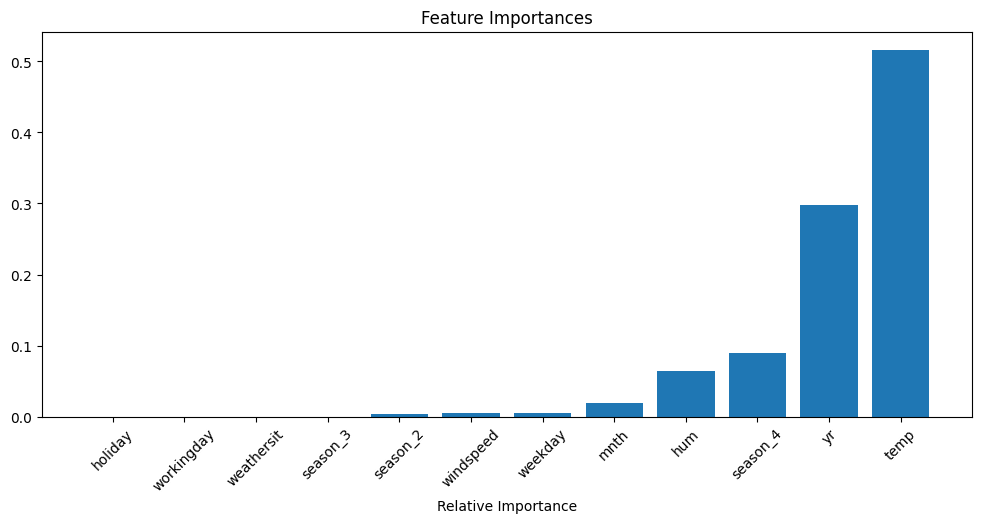

In [63]:
plt.figure(figsize=(12,5))
plt.title("Feature Importances")
plt.bar(range(len(indices)), importances[indices], align="center")
plt.xticks(range(len(indices)), [X_train.columns[i] for i in indices], rotation = 45)
plt.xlabel("Relative Importance")
plt.show()

# Business Recommendations
<br>1. The predictive model hepls us predict for any season and environmental parameters and can predict the # of the bikes to be rented.
</br><br>
2. More stations can be launched near busy workplaces or schools/colleges to reach out to their main customers since we see high usage during peak hours.
</br><br>
3. Higher # of bikes can be made available for the fall and winter seasons as the frequency of usage is high in these seasons.
</br><br>
4. As the number of frequency of usage is high for day timings compared to night timings. We can choose different prices of bikes accordingly.
</br><br>
5. Maintainance activities should be reserved for night due to non-peak hours.
</br><br>
6. Company can launch campaigns and provide promotional offers to increase usage on non-working hours or days or holidays as well.
</br>